***I. The fully theoretical computation***

In [1]:
import handcalcs.render
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import forallpeople as si

In [2]:
si.environment('custom')
si.environment()

{'Hz': 1.000 Hz, 'N': 1.000 N, 'Pa': 1.000 Pa, 'J': 1.000 J, 'W': 1.000 W, 'C': 1.000 C, 'V': 1.000 V, 'F': 1.000 F, 'Ohm': 1.000 Ω, 'S': 1.000 S, 'Wb': 1.000 Wb, 'T': 1.000 T, 'H': 1.000 H, 'Celsius': 1.000 °C, 'lux': 1.000 lux, 'Gy': 1.000 m²·s⁻², 'katal': 1.000 kat, 'minute': 1.000 minutes, 'hour': 1.000 hours, 'day': 1.000 days, 'um': 1.000 μm, 'mum_s': 1.000 µm·s⁻¹, 'muJ_mum': 1.000 mJ·µm⁻¹} 
 {'kg': 1.000 kg, 'm': 1.000 m, 's': 1.000 s, 'A': 1.000 A, 'cd': 1.000 cd, 'K': 1.000 °C, 'mol': 1.000 mol}


In [3]:
si.um.to()

Available units: 


In [4]:
uJ = (1e-6 * si.J)
MJ = 1e6*si.J
L = 1e-3*si.m**3
um = 1e-6*si.m
ug = 1e-9 * si.kg

Let's compute the amount of lipid able to pass through one hypha per unit time and the amount of power it represents (in $\mu W$)

In [5]:
%%render
rho_TAG = 0.2 #ratio of hyphal volume filled with lipids
eTAG = 30 *MJ * L**-1 #the energy density of TAG lipids
rho_e = rho_TAG*eTAG #the energy density of hypha volume
r_hypha_trunk = 5* um #Hyphal radius
v_transport = 5 *si.mum_s#speed of transport within hypha
P_trunk = pi*r_hypha_trunk**2*rho_e*v_transport #maxium potential power provided by one trunk hypha
# phi_TAG = v_transport*rho_TAG*pi*r_hypha**2 #um3.s-1
# phi_TAG = phi_TAG*3600 #um3.h-1
# d_TAG = 1/1e15*0.8*1e9 *ug * um**-3
# phi_TAG = phi_TAG*d_TAG #ug.s-1

<IPython.core.display.Latex object>

Now let's compute the theoretical energy necessary to grow one $\mu m$ of hypha

In [6]:
%%render

NA = 6.02*1e23 *si.mol**-1 #avogadro number

e_ATP= 40 * 1e3 *si.J * si.mol**-1 
L_prot = 400 
n = 3e6*um**-3/NA 
Eproteinsynthesis = 4 
r_hypha = 5 *um
e_total_prot_synth = Eproteinsynthesis*e_ATP*L_prot*n*np.pi*r_hypha**2 

<IPython.core.display.Latex object>

In [7]:
e_total_prot_synth = e_total_prot_synth.to('muJ_mum')

expressed in $mJ.\mu m^{-1}$

In [8]:
%%render
e_total_prot_synth

<IPython.core.display.Latex object>

Now we can use an estimate of the total colony growth speed to get some estimate of power requirement and compare the power necessary for growth and the one that can be provided by one trunk hypha

In [9]:
%%render

v_colony_growth = 30000 /3600*si.mum_s #total colony growth speed
P_total_protein_synthesis = e_total_prot_synth*v_colony_growth
ratio_power = P_total_protein_synthesis/P_trunk

<IPython.core.display.Latex object>

Let's compare these power to the one necessary to sustain transport in the full network

In [10]:
%%render
r_vesicle = 1 * um #assumed radius of a vesicle
e_walking = 100/NA * um**-1 #assumed number of mol of ATP for a molecular motor to walk 1um 
#(from http://book.bionumbers.org/how-fast-do-molecular-motors-move-on-cytoskeletal-filaments/)
e_ATP= 40 * 1e3 *si.J * si.mol**-1 #Energy per mol of ATP
Pwalking =v_transport * e_walking*e_ATP  #Power required to walk one molecular motor
p_transport = rho_TAG*Pwalking*r_hypha**2/(r_vesicle**3) #power required to walk all the vesicles per m of hypha
L = 1e6 *um #total length of an A5 network filling half of a split plate
P_transport = L*p_transport  #total power required to run lipid vesicles throughout the network
ratio_power = P_transport/P_total_protein_synthesis

<IPython.core.display.Latex object>

***II. The spore loading method***

Computing the energy contained in one spore

In [28]:
%%render

d_spore = 60*um #spore diameter
d_spore
spore_volume = (d_spore/2)**3*4/3*pi
rho_TAG_spore = 0.1 #the percentage of volume occupied by lipids
e_spore = spore_volume*rho_TAG*eTAG
e_spore

<IPython.core.display.Latex object>

We can then compute the length reachable by a spore of a given radius if we were to assume that the only use of carbon is in the energy used for protein synthesis

In [12]:
%%render
length_reachable = e_spore/e_total_prot_synth
length_reachable

<IPython.core.display.Latex object>

We see that reachable length should be a cubic function of spore radius with coefficient

In [13]:
%%render
a_theoretical = 4/3*pi*rho_TAG_spore*eTAG/(8*e_total_prot_synth)
d_spore
length_reachable = a_theoretical*d_spore**3

<IPython.core.display.Latex object>

Let's compare to Vasilis data with spores

In [14]:
data = pd.read_excel("vasilis_data.xlsx",sheet_name="Experiment 1")
data = data.loc[data['THL']<=30000]
data = data.loc[data['SD']<=150]
data = data.sort_values(by="SD")

data_dik = data.loc[data['Karyosis']=='Dikaryon'].copy()
data_hom = data.loc[data['Karyosis']=='Homokaryon'].copy()
rolling = 20
for sub_data in [data_hom,data_dik,data]:
    sub_data['THL_mean']=sub_data["THL"].rolling(rolling).mean()
    sub_data['THL_sup']=sub_data["THL"].rolling(rolling,center=True).quantile(0.9)
    sub_data['rolling average total_growth (um)']=sub_data['THL_mean']
    sub_data['rolling sup total_growth (um)']=sub_data['THL_sup']
    sub_data['logTHL']=np.log(sub_data["THL"])
    sub_data['logTHL_mean']=sub_data["logTHL"].rolling(rolling).mean()
    sub_data['logTHL_sup']=sub_data["logTHL"].rolling(rolling).quantile(0.9)

We do a rolling 90th percentile to really get the data corresponding to maximum growth of spores

Text(0, 0.5, 'Total hyphal length ($\\mu m$)')

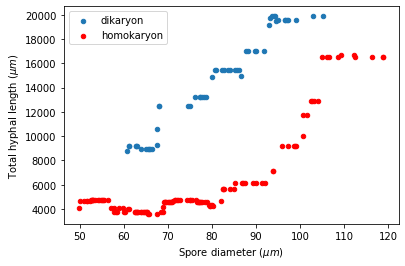

In [15]:
fig, ax = plt.subplots()
data_dik.plot('SD','THL_sup',kind="scatter",ax=ax,label="dikaryon")
data_hom.plot('SD','THL_sup',kind="scatter",ax=ax,color='red',label="homokaryon")
ax.set_xlabel('Spore diameter ($\mu m$)')
ax.set_ylabel('Total hyphal length ($\mu m$)')

Bigger spores indeed create longer hyphae. The plateauing at the end is an artefact of the rolling statistics and should be ignored.
We can also already see that the range of reachable length matches the order of magnitude of the theoretical one : $13mm$ for a $ 60 \mu m $ spore filled with $10\%$ of its volume occupied by lipids

We can get a finer estimates of the $a$ coefficient by doint a curve fit assuming the cubic dependence

In [16]:
from scipy.optimize import curve_fit
def cubic(x,a):
    return(a*x**3)

We can then fit a cubic function to the data to find its coefficient.

In [17]:
data_select = data_dik.loc[~data_dik['THL_sup'].isnull()]
popt,cov = curve_fit(cubic, data_select['SD'],data_select['THL_sup'],bounds = ([0],[np.inf]),p0=[1])

Text(0, 0.5, 'Total hyphal length ($\\mu m$)')

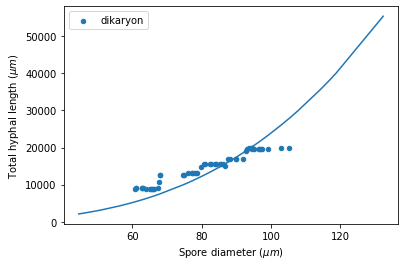

In [18]:
fig, ax = plt.subplots()
data_dik.plot('SD','THL_sup',kind="scatter",ax=ax,label="dikaryon")
ax.plot(data_dik['SD'],popt[0]*data_dik['SD']**3)
ax.set_xlabel('Spore diameter ($\mu m$)')
ax.set_ylabel('Total hyphal length ($\mu m$)')

In [19]:
%%render
a_data = popt[0] * um**-2
a_theoretical

<IPython.core.display.Latex object>

but in reality, the carbon brought in the lipid is both the energy used for protein synthesis and the carbon building block of the newly built biomass. It it therefore expected that the theoretical value is higher. How much C is there in the fungal biomass and to what amount of lipids does this correspond to? Harvest data indicate about $1mg$ of dry fungal biomass in the fungal compartment after full growth. According to [here](https://www.researchgate.net/publication/318418100_CarbonNitrogenPhosphorus_Stoichiometry_in_Fungi_A_Meta-Analysis), about 50% of this biomass is carbon.

Most fatty acids in AMF have between 16 and 20 carbons. The majority is palmitic acid according to [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5559270/) whose formula is $C_{16}H_{32}O_{2}$ the proportion of the mass that is due to carbon is

In [33]:
ratio_TAG_C = 16*12/(16*12+32+2*16)
ratio_TAG_C

0.75

In [21]:
%%render

m_fungus = 1e-6 *si.kg
ratio_C = 0.5
m_carbon = ratio_C * m_fungus #the amount of carbon in the fungal half at the end of the experiment
L_colony = 1*si.m #the total length of the colony
d_C = m_carbon/L_colony #amount of carbon per unit length of hypha
d_TAG = 1000 *si.kg*si.m**-3 #the density TAG
V_TAG  = d_C/(d_TAG*ratio_TAG_C) #the volume of lipid that has to be brought per unit length hypha
Phi_TAG_biomass = V_TAG *v_colony_growth

<IPython.core.display.Latex object>

Lets compare to the use of TAG as energy

In [22]:
%%render
Phi_TAG_energy = P_total_protein_synthesis/rho_e
ratio = Phi_TAG_energy/Phi_TAG_biomass

<IPython.core.display.Latex object>

How much carbon in one meter of hypha in theory. To estimate this, one needs to get three values. The two first ones are the buoyant density $d_{biomass}$ and the dry mass to wet mass ratio $r_{d/w}$. One can find values for this in the literrature [here](https://journals.asm.org/doi/epdf/10.1128/aem.45.4.1188-1195.1983) . For fungi they find $d_{biomass} =1.1$ and $r_{d/w}=0.2$. In our case, since AMF are lipid rich we could imagine this ratio being higher (lipids fill some water volume therefore increasing $r_{d/w}$). This alreay yields an estimate of what the dry biomass in the fungal compartment should be.

In [23]:
%%render
V_total = L_colony*pi*r_hypha**2
d_biomass = 1100 *si.kg*si.m**-3
m_wet = V_total * d_biomass
r_dw=0.2
m_dry = m_wet*r_dw

<IPython.core.display.Latex object>

This is very far from what comes out of the harvest data. I cannot explain the discrepancy at this stage. Let's continue with the theoretical value. We need to know another factor $r_{C/Tot}$ which is the ratio of the dry mass that is carbon. We find values for this [here](https://www.frontiersin.org/articles/10.3389/fmicb.2017.01281/full), it varies between fungal species but we can take $r_{C/Tot}=0.4$

In [24]:
%%render

r_CTot = 0.4
m_C = m_dry * r_CTot
m_C

<IPython.core.display.Latex object>

Through this path, we can get an estimate of the carbon required for the growth per unit length hypha for biomass material

In [25]:
%%render

m_L_C = pi*r_hypha**2*d_biomass*r_dw*r_CTot #the mass of carbon necesarry per unit length
V_TAG_biomass_theory = m_L_C/(d_TAG*ratio_TAG_C) #the volume of TAG necessary per unit length, assuming all mass of TAG is carbon

<IPython.core.display.Latex object>

We can compare the volume of TAG necessary per unit length of hypha for protein synthesis

In [26]:
%%render

V_TAG_energy_theory=Phi_TAG_energy/v_colony_growth

<IPython.core.display.Latex object>

Then total TAG necessary per $\mu m$ of hyphal growth is then 

In [27]:
%%render

V_TAG_theory= V_TAG_energy_theory + V_TAG_biomass_theory

<IPython.core.display.Latex object>

We can compare this to the experimental value obtained from spore data, as a reminder

In [32]:
%%render
rho_TAG_spore = 0.1
V_TAG_experiment = 4/3*pi*rho_TAG_spore/a_data
V_TAG_experiment

<IPython.core.display.Latex object>